## Importing the libraries

In [54]:
from __future__ import absolute_import, print_function,division, unicode_literals

import os.path
import glob
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [55]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#### Check dataset directories

In [56]:
print(os.listdir("maize_dataset/train"))
print(os.listdir("maize_dataset/val"))
print(os.listdir("maize_dataset/test_images"))

['Maize Streak Virus', 'Northern Leaf Blight', 'Healthy', 'Gray Leaf Spot', 'Maize Common Smut']
['Maize Streak Virus', 'Northern Leaf Blight', 'Healthy', 'Gray Leaf Spot', 'Maize Common Smut']
['h_1.jpg', 'h_4.jpg', 'h_0.jpg', 'h_2.jpg', 'h_3.jpg']


## Function to check the tflite file size

In [57]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

## Function to convert KB to MB 


In [58]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + 'bytes')
        

### Preparing the training and validation dataset

In [59]:
'''
train_dir = 'maize_dataset/train'
test_dir = 'maize_dataset/test'
valid_dir = 'maize_dataset/valid'
'''

"\ntrain_dir = 'maize_dataset/train'\ntest_dir = 'maize_dataset/test'\nvalid_dir = 'maize_dataset/valid'\n"

In [61]:
data_dir = 'maize_dataset'
data_dir = pathlib.Path(data_dir)
CLASS_NAMES = ['Gray Leaf Spot','Healthy','Maize Common Smut','Maize Streak Virus','Northern Leaf Blight']
print("Class names", CLASS_NAMES)

Class names ['Gray Leaf Spot', 'Healthy', 'Maize Common Smut', 'Maize Streak Virus', 'Northern Leaf Blight']


In [63]:
for cl in CLASS_NAMES:
    data_path = os.path.join(data_dir, cl)
    images = glob.glob(data_path + "/*")
    print("{} :{} ".format(cl,len(images)))
    train, val = images[:round(len(images)*0.8)],images[round(len(images)*0.8):]
    
    for t in train:
        if not os.path.exists(os.path.join(data_dir, 'train', cl)):
            os.makedirs(os.path.join(data_dir, 'train', cl))
        shutil.move(t,os.path.join(data_dir, 'train', cl))
        
    for v in val:
        if not os.path.exists(os.path.join(data_dir, 'val', cl)):
            os.makedirs(os.path.join(data_dir, 'val', cl))
        shutil.move(v,os.path.join(data_dir, 'val', cl))
    
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

Gray Leaf Spot :0 
Healthy :0 
Maize Common Smut :0 
Maize Streak Virus :0 
Northern Leaf Blight :0 


## List classes

In [64]:
classes = os.listdir(train_dir)
print('classes: ', classes)

classes:  ['Maize Streak Virus', 'Northern Leaf Blight', 'Healthy', 'Gray Leaf Spot', 'Maize Common Smut']


In [65]:
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32

## Data Preprocessing

In [77]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_directory(train_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='sparse')

img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               class_mode='sparse')

Found 1332 images belonging to 5 classes.
Found 334 images belonging to 5 classes.


In [79]:
def displayImages(img_arr):
    fig,axes = plt.subplots(1,5,figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

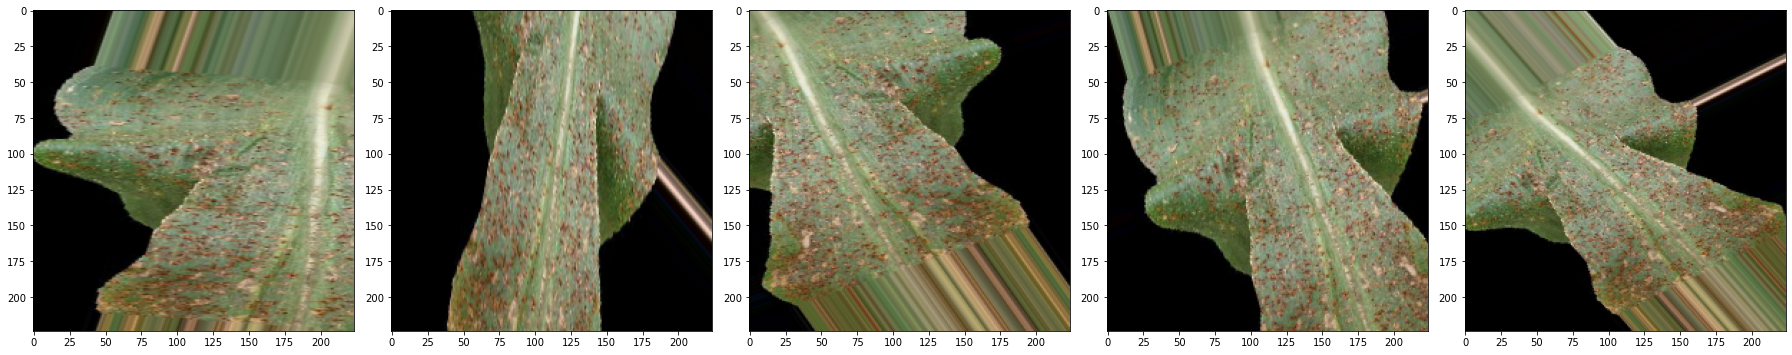

In [80]:
img_array = [train_data_gen[0][0][0] for i in range(5)]
displayImages(img_array)

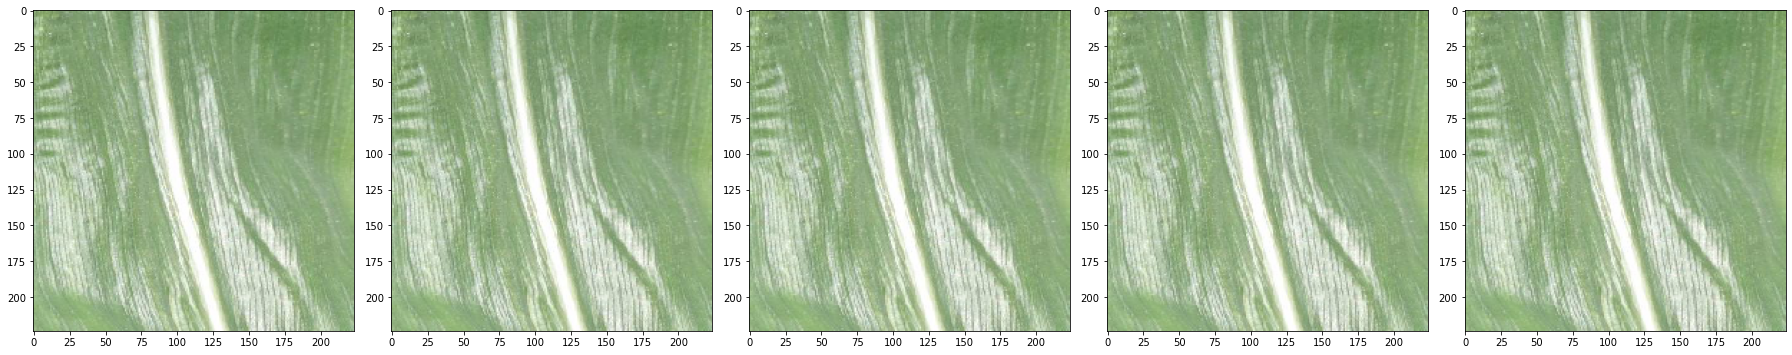

In [81]:
img_array  = [val_data_gen[0][0][0] for i in range(5)]
displayImages(img_array)

In [82]:
def getInfo(generator):
    print("Samples:",generator.samples)
    print("No of classes:",generator.num_classes)
    print("Batch size:", generator.batch_size)
    print("Data format:", generator.dtype)
    print("Color mode:",generator.color_mode)
    print("Image shape:", generator.image_shape)
    print("Allowed class modes:", generator.allowed_class_modes)
    print("Class Mode:", generator.class_mode)

In [83]:
getInfo(train_generator)

Samples: 1067
No of classes: 5
Batch size: 32
Data format: float32
Color mode: rgb
Image shape: (224, 224, 3)
Allowed class modes: {None, 'sparse', 'input', 'binary', 'categorical'}
Class Mode: categorical


In [84]:
getInfo(val_generator)

Samples: 64
No of classes: 5
Batch size: 32
Data format: float32
Color mode: rgb
Image shape: (224, 224, 3)
Allowed class modes: {None, 'sparse', 'input', 'binary', 'categorical'}
Class Mode: categorical


## Build the model

In [85]:
import glob
classes = len(glob.glob(train_dir+"/*"))

In [86]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

In [89]:
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

## Train the model

In [91]:
EPOCHS = 10
history = model.fit_generator(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen)

Epoch 1/10
42/42 [==============================] - 67s 2s/step - loss: 0.8717 - accuracy: 0.3371 - val_loss: 0.4058 - val_accuracy: 0.3114
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 0.5403 - accuracy: 0.3093 - val_loss: 0.4639 - val_accuracy: 0.3084
Epoch 3/10
42/42 [==============================] - 57s 1s/step - loss: 0.4893 - accuracy: 0.3033 - val_loss: 0.3245 - val_accuracy: 0.3084
Epoch 4/10
42/42 [==============================] - 56s 1s/step - loss: 0.4176 - accuracy: 0.3056 - val_loss: 0.3471 - val_accuracy: 0.3114
Epoch 5/10
42/42 [==============================] - 57s 1s/step - loss: 0.3877 - accuracy: 0.3033 - val_loss: 0.2795 - val_accuracy: 0.3234
Epoch 6/10
42/42 [==============================] - 56s 1s/step - loss: 0.3868 - accuracy: 0.3078 - val_loss: 0.2466 - val_accuracy: 0.3174
Epoch 7/10
42/42 [==============================] - 56s 1s/step - loss: 0.3495 - accuracy: 0.3003 - val_loss: 0.2657 - val_accuracy: 0.3234
Epoch 8/10
42/42 [==

## Check the performance

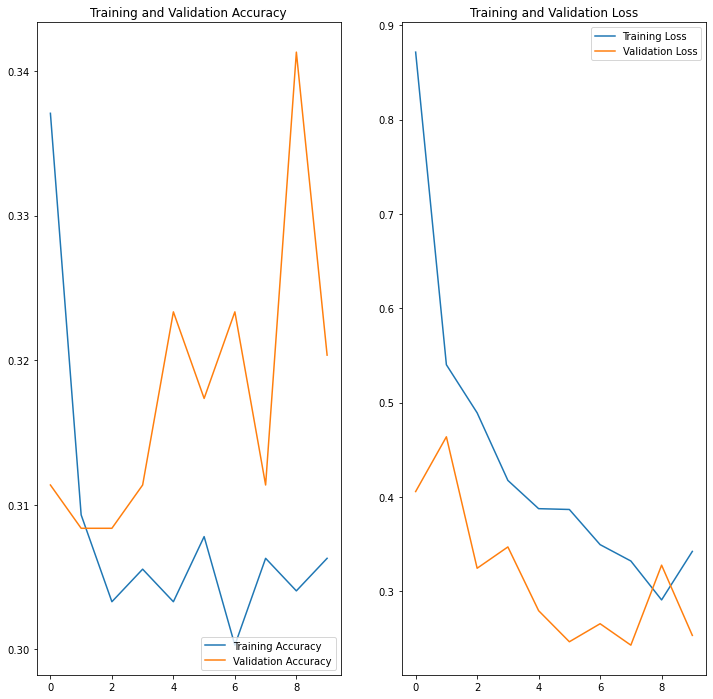

In [92]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Export as saved model and convert to TFLite

In [93]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

2022-08-06 18:57:26.702301: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/1/assets


In [94]:
mode = "Default" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT
  
optimization

<Optimize.DEFAULT: 'DEFAULT'>

In [95]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

2022-08-06 18:58:14.781574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-08-06 18:58:14.781623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-08-06 18:58:14.781640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-08-06 18:58:14.809052: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_model/1
2022-08-06 18:58:14.823023: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-08-06 18:58:14.823080: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_model/1
2022-08-06 18:58:14.841554: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2022-08-06 18:58:15.003218: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: saved_model/1
2022-08-06 1

In [96]:
tflite_model_file = 'maize.tflite'

with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

with open('labels.txt', 'w') as f:
  f.write('\n'.join(CLASS_NAMES))

In [97]:
!ls

final.ipynb  labels.txt  maize_dataset	maize.tflite  saved_model
